In [1]:
import proplot as pplt
import pyart                             
import matplotlib.pyplot as plt          
import cartopy.crs as ccrs               
import numpy as np                       
import glob                              
import pandas as pd                      
import salem                             
from datetime import datetime, timedelta 
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#### IMPORTANTE:
### Configurando caminhos:
path_radar = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/Dados_radares_FCTH/Salesopolis_selected/2200as2255/'
path_raios = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/12_01_24_completo.pickle'
path_shapefiles = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/'
output = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/'

### 1) Lendo e gerando indicadores CAPPI com os dados de radar:

In [3]:
############################################################
### Verificando a quantidade de arquivos de radar na pasta:
files = glob.glob(path_radar+'P*.HDF5')
print(len(files))

######################### Função para gerar dicionario com as informações de cada arquivo de radar:
def gera_radares_pyart(file):
    radar = pyart.aux_io.read_gamic(f'{file}')

    lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
    altitude = radar.altitude['data'][0]
    latmin, latmax = radar.gate_latitude['data'].min(), radar.gate_latitude['data'].max()
    lonmin, lonmax = radar.gate_longitude['data'].min(), radar.gate_longitude['data'].max()
    data = pyart.util.datetime_from_grid(radar)
    ano = str(data.year)
    mes = str(data.month).zfill(2)
    dia = str(data.day).zfill(2)
    hor = str(data.hour).zfill(2)
    min = str(data.minute).zfill(2)

    dic = {'radar':radar, 'lat_radar':lat_radar, 'lon_radar':lon_radar,
           'data':[ano, mes, dia, hor, min], 'altitude':altitude, 
           'extent':[lonmin, lonmax, latmin, latmax]}

    return dic 

#========================================================================================================================#
#  LEITURA DADOS DO RADAR - Chama a função acima e gera uma lista de dicionários, 1 dicionario para cada arquivo de radar
#========================================================================================================================#
dics_radares = [gera_radares_pyart(file) for file in files]
print(len(dics_radares))

12
12


In [4]:
######################### Função para gerar indicador CAPPI. Aqui devem ser configurados a quantidade de pontos
######################### nas direções z, x e y, além dos limites da grade do radar:
def gera_cappis(radar, altitude, lat_radar, lon_radar):
    cappi = pyart.map.grid_from_radars(radar, grid_shape=(8, 500, 500),
                                       grid_limits=((6928. - altitude, 8928.- altitude),
                                                   (-240000., 240000.),
                                                   (-240000., 240000.)),
                                       grid_origin=(lat_radar, lon_radar),
                                       gridding_algo='map_gates_to_grid',
                                       roi_func='dist_beam',
                                       weighting_function='Nearest',
                                       fields=['corrected_reflectivity'])
    
    ### Transformando CAPPI do Py-ART para Dataset do Xarray:
    ds = cappi.to_xarray()
    return ds

#========================================================================================================================#
#      GERANDO O CAPPI - Chama a função acima e gera uma lista de Datasets Xarray, 1 array para cada arquivo de radar
#========================================================================================================================#
lista_cappis = [gera_cappis(d['radar'], d['altitude'], d['lat_radar'], d['lon_radar']) for d in dics_radares]

In [5]:
#========================================================================================================================#
#                                 Filtrando/Selecionando somente refletividades >= 20 dBZ
#========================================================================================================================#
cappis_filtrados = [ds.where(ds['corrected_reflectivity'] >= 20, drop=False) for ds in lista_cappis]

### 2) Lendo os dados de raios do pickle e selecionando somente os ocorridos dentro dos limites do radar:

In [6]:
#========================================================================================================================#
#           LEITURA DOS DADOS DE RAIOS - lendo o arquivo pickle obtido a partir dos dados (dump) do BrasilDat!
#========================================================================================================================#
df = pd.read_pickle(path_raios)

In [7]:
######################### Função para gerar dataframe com a localização dos raios dentro dos limites do radar:
def seleciona_raios_10min_no_campo_visao_radar(ano, mes, dia, hora, minuto):
    data_str_ini = str(datetime(int(ano), int(mes), int(dia), int(hora), int(minuto), 0, 1))
    data_str_end = str(datetime.strptime(data_str_ini, '%Y-%m-%d %H:%M:%S.%f') + timedelta(minutes=4, seconds=59, microseconds=999998))
    print('De {0} a {1}'.format(data_str_ini, data_str_end))
    print('------------------------------------')
    
    ### Procurando no dataframe os raios dentro do scan_time do radar. Exemplo: df_raios.loc['2023-02-18 23:25': '2023-02-18 23:35']
    df_raios = df.loc[data_str_ini : data_str_end]
    
    ### Lendo a posição do radar:
    latitu_radar = float(dics_radares[0]['lat_radar'])
    longitu_radar = float(dics_radares[0]['lon_radar'])
    
    ### Calcula a distância dos raios ao radar:
    dis = (np.sqrt( (df_raios['latitude'].values - latitu_radar)**2 +  (df_raios['longitude'].values - longitu_radar)**2 ) ) * 111.195

    ### Adiciona no DataFrame a coluna com a distância calculada:
    df_raios['distancia'] = dis 

    ### Selecionando os raios que estão dentro da área do radar (<= 250 km da posição do radar):
    df_raios2 = df_raios[df_raios['distancia'] <= 240] 

    return df_raios2

In [8]:
#========================================================================================================================#
#       Chamando a função para procurar os raios que ocorreram nos 10 minutos após o início de cada scan do radar
#       e gerando uma lista para cada arquivo de radar
#========================================================================================================================#
lista_dfraios2 = [seleciona_raios_10min_no_campo_visao_radar(d['data'][0], d['data'][1], d['data'][2], 
                                                              d['data'][3], d['data'][4]) for d in dics_radares]

De 2024-01-12 22:35:00.000001 a 2024-01-12 22:39:59.999999
------------------------------------
De 2024-01-12 22:45:00.000001 a 2024-01-12 22:49:59.999999
------------------------------------
De 2024-01-12 22:15:00.000001 a 2024-01-12 22:19:59.999999
------------------------------------
De 2024-01-12 22:40:00.000001 a 2024-01-12 22:44:59.999999
------------------------------------
De 2024-01-12 22:30:00.000001 a 2024-01-12 22:34:59.999999
------------------------------------
De 2024-01-12 22:25:00.000001 a 2024-01-12 22:29:59.999999
------------------------------------
De 2024-01-12 22:50:00.000001 a 2024-01-12 22:54:59.999999
------------------------------------
De 2024-01-12 22:10:00.000001 a 2024-01-12 22:14:59.999999
------------------------------------
De 2024-01-12 22:05:00.000001 a 2024-01-12 22:09:59.999999
------------------------------------
De 2024-01-12 22:55:00.000001 a 2024-01-12 22:59:59.999999
------------------------------------
De 2024-01-12 22:00:00.000001 a 2024-01-

### 3) Gerando elementos de grade a partir da posição do radar:

#### a) Construido grades de 10x10km e somando a quantidade de raios em cada uma delas:

In [9]:
######################### Função para dar um offset em qualquer lat/lon por x, y metros:
### Sintaxe: lat_long_offset(lat_radar, lon_radar, X, Y)
def lat_long_offset(lat, lon, x, y):
    '''
    lat, lon : Provide lat lon coordinates
    x, y : Provide offset of x and y on lat and long respectively
           This needs to be in meters!
           
    The approximation is taken from an aviation formula from this stack exchange 
    https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters
    ''' 
    ### Raio da Terra:
    R=6378137

    ### Offsets em radianos:
    dLat = x/R
    dLon = y/(R*np.cos(np.pi*lat/180))

    ### Posição de cada offset, em graus decimais:
    latO = lat + dLat * 180/np.pi
    lonO = lon + dLon * 180/np.pi
    
    return latO, lonO

lat_long_offset_vec = np.vectorize(lat_long_offset)

In [10]:
######################### Função para criar as grades e retornar as coordenadas:
### Sintaxe: get_mesh(lat_radar, lon_radar, tamannho de cada grade em metros, metade da quantidade de grades nas direções x e y). Ex:
### get_mesh(lat_radar, lon_radar, 10000, 25)
def get_mesh(lat, lon, dist, coors):
    mini, maxi = -dist*coors, dist*coors
    n_coord = coors*2+1
    axis = np.linspace(mini, maxi, n_coord) 
    X, Y = np.meshgrid(axis, axis)
    mesh = lat_long_offset_vec(lat, lon, X, Y)
    mesh_x_y_format = np.stack(mesh).transpose(1,2,0)
    return mesh_x_y_format

In [11]:
######################### Função para gerar as grades, percorrê-las e contar a quantidade de raios em cada uma:
def grade_10km_contagens_raios(df_raios2, lat_radar, lon_radar):
    ### https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html (transforma lat/lon para pontos x e y):
    gdf = gpd.GeoDataFrame(df_raios2, geometry=gpd.points_from_xy(df_raios2['longitude'], df_raios2['latitude']), crs="EPSG:4326")

    ### Chamando as funções que constroem a grade:
    output = get_mesh(lat_radar, lon_radar, 10000, 25)
    
    def Swap(arr, start_index, last_index): 
        arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
    for i in range(len(output)):
        Swap(output[i], 0, 1)

    ############################################################################################
    ### Lista com 50 listas:
    lista_listas_linhasx_conts = []
    for i in range(len(np.arange(0, 50, 1))):
        lista_listas_linhasx_conts.append([])

    ############################################################################################
    ##### Percorrendo as grades e contando e inserindo a quantidade total de raios em cada uma:
    p = np.arange(0, 50, 1)
    cont = 0
    for j in range(len(p)):
        # print(j)
        for i in range(len(p)):
            for index, row in gdf.iterrows():
                if ((row['longitude']>=output[i][j][0]) and (row['longitude']<=output[i+1][j][0] and 
                    (row['latitude']>=output[i][j][1]) and (row['latitude']<=output[i+1][j+1][1]))):
                    cont = cont + 1
            if cont > 0:
                lista_listas_linhasx_conts[j].append(cont)
            elif cont == 0:
                lista_listas_linhasx_conts[j].append(np.nan)
            cont = 0
            
    return lista_listas_linhasx_conts

In [12]:
#=======================================================================================================================================#
# Para cada arquivo de radar gerando uma lista de 50 listas, onde cada lista interna tem 50 quantidades de raios
#=======================================================================================================================================#
dic_raios = {}
for i in range(len(lista_dfraios2)):
    dic_raios.setdefault('radar_{0}'.format(i), grade_10km_contagens_raios(lista_dfraios2[i],
                                                                           dics_radares[i]['lat_radar'],
                                                                           dics_radares[i]['lon_radar']))

#### b) Construido grade de 10x10km e calculando estatísticas da refletividade em cada uma:

In [13]:
######################### Função para gerar as grades, percorrê-las e calcular média em cada uma:
def grade_10km_medias_refletividades(ds_filt, lat_radar, lon_radar):
    
    ##### Chamando as funções que controem a grade:
    output = get_mesh(lat_radar, lon_radar, 10000, 25)
    
    def Swap(arr, start_index, last_index): 
        arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
    for i in range(len(output)):
        Swap(output[i], 0, 1)

    ############################################################################################
    ##### Lista com 50 listas para as médias:
    lista_listas_linhasx_means = []
    for i in range(len(np.arange(0, 50, 1))):
        lista_listas_linhasx_means.append([])

    ############################################################################################
    ##### Inserindo a média de dBZ em cada grade:
    temp = ds_filt['corrected_reflectivity'][0, 0, :, :]
    p = np.arange(0, 50, 1)
    for j in range(len(p)):
        for i in range(len(p)):
            mask = ( (temp.coords["lon"]>=output[i][j][0]) & (temp.coords["lon"]<=output[i+1][j][0])
                    &(temp.coords["lat"]>=output[i][j][1]) & (temp.coords["lat"]<=output[i+1][j+1][1]))
            lista_listas_linhasx_means[j].append(np.nanmean(temp.where(mask).values))
    return lista_listas_linhasx_means

In [14]:
######################### Função para gerar as grades, percorrê-las e calcular mediana em cada uma:
def grade_10km_medianas_refletividades(ds_filt, lat_radar, lon_radar):
    
    ##### Chamando as funções que controem a grade:
    output = get_mesh(lat_radar, lon_radar, 10000, 25)
    
    def Swap(arr, start_index, last_index): 
        arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
    for i in range(len(output)):
        Swap(output[i], 0, 1)

    ############################################################################################
    ##### Lista com 50 listas para as medianas:
    lista_listas_linhasx_medians = []
    for i in range(len(np.arange(0, 50, 1))):
        lista_listas_linhasx_medians.append([])

    ############################################################################################
    ##### Inserindo a mediana de dBZ em cada grade:
    temp = ds_filt['corrected_reflectivity'][0, 0, :, :]
    p = np.arange(0, 50, 1)
    for j in range(len(p)):
        for i in range(len(p)):
            mask = ( (temp.coords["lon"]>=output[i][j][0]) & (temp.coords["lon"]<=output[i+1][j][0])
                    &(temp.coords["lat"]>=output[i][j][1]) & (temp.coords["lat"]<=output[i+1][j+1][1]))
            lista_listas_linhasx_medians[j].append(np.nanmedian(temp.where(mask).values))
    return lista_listas_linhasx_medians

In [15]:
######################### Função para gerar as grades, percorrê-las e calcular máxima em cada uma:
def grade_10km_maximas_refletividades(ds_filt, lat_radar, lon_radar):
    
    ##### Chamando as funções que controem a grade:
    output = get_mesh(lat_radar, lon_radar, 10000, 25)
    
    def Swap(arr, start_index, last_index): 
        arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
    for i in range(len(output)):
        Swap(output[i], 0, 1)

    ############################################################################################
    ##### Lista com 50 listas para as máximas:
    lista_listas_linhasx_maxs = []
    for i in range(len(np.arange(0, 50, 1))):
        lista_listas_linhasx_maxs.append([])

    ############################################################################################
    ##### Inserindo a dBZ máxima em cada grade:
    temp = ds_filt['corrected_reflectivity'][0, 0, :, :]
    p = np.arange(0, 50, 1)
    for j in range(len(p)):
        for i in range(len(p)):
            mask = ( (temp.coords["lon"]>=output[i][j][0]) & (temp.coords["lon"]<=output[i+1][j][0])
                    &(temp.coords["lat"]>=output[i][j][1]) & (temp.coords["lat"]<=output[i+1][j+1][1]))
            lista_listas_linhasx_maxs[j].append(np.nanmax(temp.where(mask).values))
    return lista_listas_linhasx_maxs

In [16]:
#=======================================================================================================================================#
# Para cada CAPPI (6 km) filtrado gerando uma lista de listas, onde cada lista interna tem 50 médias da refletividade >= 20 dBZ
#=======================================================================================================================================#
dic1 = {}
for i in range(len(cappis_filtrados)):
    dic1.setdefault('radar_{0}'.format(i), grade_10km_medias_refletividades(cappis_filtrados[i], 
                                                                           dics_radares[i]['lat_radar'],
                                                                           dics_radares[i]['lon_radar']))

In [17]:
#=======================================================================================================================================#
# Para cada CAPPI (6 km) filtrado gerando uma lista de listas, onde cada lista interna tem 50 medianas da refletividade >= 20 dBZ
#=======================================================================================================================================#
dic2 = {}
for i in range(len(cappis_filtrados)):
    dic2.setdefault('radar_{0}'.format(i), grade_10km_medianas_refletividades(cappis_filtrados[i], 
                                                                           dics_radares[i]['lat_radar'],
                                                                           dics_radares[i]['lon_radar']))

In [18]:
#=======================================================================================================================================#
# Para cada CAPPI (6 km) filtrado gerando uma lista de listas, onde cada lista interna tem 50 máximas da refletividade >= 20 dBZ
#=======================================================================================================================================#
dic3 = {}
for i in range(len(cappis_filtrados)):
    dic3.setdefault('radar_{0}'.format(i), grade_10km_maximas_refletividades(cappis_filtrados[i], 
                                                                           dics_radares[i]['lat_radar'],
                                                                           dics_radares[i]['lon_radar']))

### 4) Juntando todas as listas (resultantes das varreduras ao longo das grades) numa só:

In [19]:
refletividades_cappi6_filtradas = []
numero_total_raios = []
refletividades_cappi6_filtradas_medianas = []
refletividades_cappi6_filtradas_maximas = []

for listaext in dic1.values():
    for listaint in listaext:
        for r in listaint:
            refletividades_cappi6_filtradas.append(r)

for listaext in dic_raios.values():
    for listaint in listaext:
        for qnt in listaint:
            numero_total_raios.append(qnt)

for listaext2 in dic2.values():
    for listaint2 in listaext2:
        for r2 in listaint2:
            refletividades_cappi6_filtradas_medianas.append(r2)

for listaext3 in dic3.values():
    for listaint3 in listaext3:
        for r3 in listaint3:
            refletividades_cappi6_filtradas_maximas.append(r3)

In [20]:
######################### Gerando dataframe com o total de raios e as médias das refletividades ######################### 
di = {'total_raios': numero_total_raios, 'refletividade_filtrada_medias': refletividades_cappi6_filtradas} 
df = pd.DataFrame(di)
final_medias = df.dropna(axis=0, how='any')

### Eliminando as linhas onde o total de raios detectado em solo é menor que 10:
mask = (final_medias['total_raios'] < 10.0)
final_medias = final_medias.loc[~mask]
final_medias

### Extraindo e salvando o dataframe para um aqruivo pickle:
final_medias.to_pickle(output+'12_01_24_MEDIAS_2200as2255.pickle')

In [21]:
######################### Gerando dataframe com o total de raios e as medianas das refletividades ######################### 
di2 = {'total_raios': numero_total_raios, 'refletividade_filtrada_medianas': refletividades_cappi6_filtradas_medianas} 
df2 = pd.DataFrame(di2)
final_medianas = df2.dropna(axis=0, how='any')

##### Eliminando as linhas onde o total de raios detectado em solo é menor que 10:
mask2 = (final_medianas['total_raios'] < 10.0)
final_medianas = final_medianas.loc[~mask2]
final_medianas

### Extraindo e salvando o dataframe para um aqruivo pickle:
final_medianas.to_pickle(output+'12_01_24_MEDIANAS_2200as2255.pickle')

In [22]:
######################### Gerando dataframe com o total de raios e as refletividades máximas #########################
di3 = {'total_raios': numero_total_raios, 'refletividade_filtrada_maximas': refletividades_cappi6_filtradas_maximas} 
df3 = pd.DataFrame(di3)
final_maximas = df3.dropna(axis=0, how='any')

### Eliminando as linhas onde o total de raios detectado em solo é menor que 10:
mask3 = (final_maximas['total_raios'] < 10.0)
final_maximas = final_maximas.loc[~mask3]
final_maximas

### Extraindo e salvando o dataframe para um aqruivo pickle:
final_maximas.to_pickle(output+'12_01_24_MAXIMAS_2200as2255.pickle')

### 5) Opcional: Plotando indicadores CAPPI sobrepostos às localizações dos raios:

In [23]:
#========================================================================================================================#
#    PLOTANDO refletividades >= 20 dBZ (para CAPPI de 6000m) e para somente os raios
#    que coincidem com a área de visão do radar!!!!!!!!!!!
#========================================================================================================================#
def plota_junto(xarray_cappi, dic_radar, df_raios):
    ### Define a altura que será plotada:
    indice_altura = 0 #(=6000m)
    # altura = int(xarray_cappi['z'][indice_altura] - dic_radar['altitude'])
    altura = int(xarray_cappi['z'][indice_altura])
    
    #### Define os limites de dBz na escala:
    limdbz = [0, 70]
    passo = 2.0
    
    ### Cria moldura da figura:
    fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')
    
    ### Limites da imagem:
    lonmin, lonmax = float(xarray_cappi['lon'].min()), float(xarray_cappi['lon'].max())
    latmin, latmax = float(xarray_cappi['lat'].min()), float(xarray_cappi['lat'].max())
    
    ### Extraindo a data do dado do radar:
    data = pyart.util.datetime_from_grid(dic_radar['radar'])
    ano = str(data.year)
    mes = str(data.month).zfill(2)
    dia = str(data.day).zfill(2)
    hor = str(data.hour).zfill(2)
    minuto = str(data.minute).zfill(2)
    
    ### Formatação dos eixos
    ax.format(coast=False, borders=False, innerborders=False, labels=True, latlines=1, lonlines=1,
              title = f'CAPPI {altura} m: {ano}-{mes}-{dia} às {hor}:{minuto} UTC',
              latlim=(latmin-0.07, latmax+0.06),
              lonlim=(lonmin-0.05, lonmax+0.05), small='19px', large='20px', abc=True, abcstyle='a', abcsize=1)
    
    ### Plotando mapa com os valores de refletividade corrigida e filtrada para R >= 20 dBZ:
    map1 = ax.contourf(xarray_cappi['lon'], xarray_cappi['lat'],
                       xarray_cappi['corrected_reflectivity'][0, indice_altura, :, :],
                       cmap='pyart_NWSRef', alpha=0.5, fontsize = 12,
                       levels=pplt.arange(float(limdbz[0])+0.1, float(limdbz[1]), passo), vmin=limdbz[0], vmax=limdbz[1])
    
    ### Usando shapefiles do IBGE:
    ## Lendo shapefile de todos Estados do Brasil:
    estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
    ## Selecionando os Estados que o radar abrange:
    estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
    ## Desenhando o contorno dos estados:
    estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)
    
    ### Plotando somente os raios que coincidem com a área varrida pelo radar:
    ax.scatter(df_raios['longitude'].values, df_raios['latitude'].values, transform=ccrs.PlateCarree(), marker='x', s=65, color='black',
               label=f'IN+NS={str(df_raios.shape[0])}')
    
    ### Adicionando paleta de cores e legenda:
    fig.colorbar(map1, loc='r', label='Refletividade (dBZ)', ticks=10, ticklabelsize=14, labelsize=14, width=0.3, space=-1.5)
    ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.8)

    ### Salvando a figura:
    plt.savefig(output+'fig_{0}_{1}.png'.format(hor, minuto))

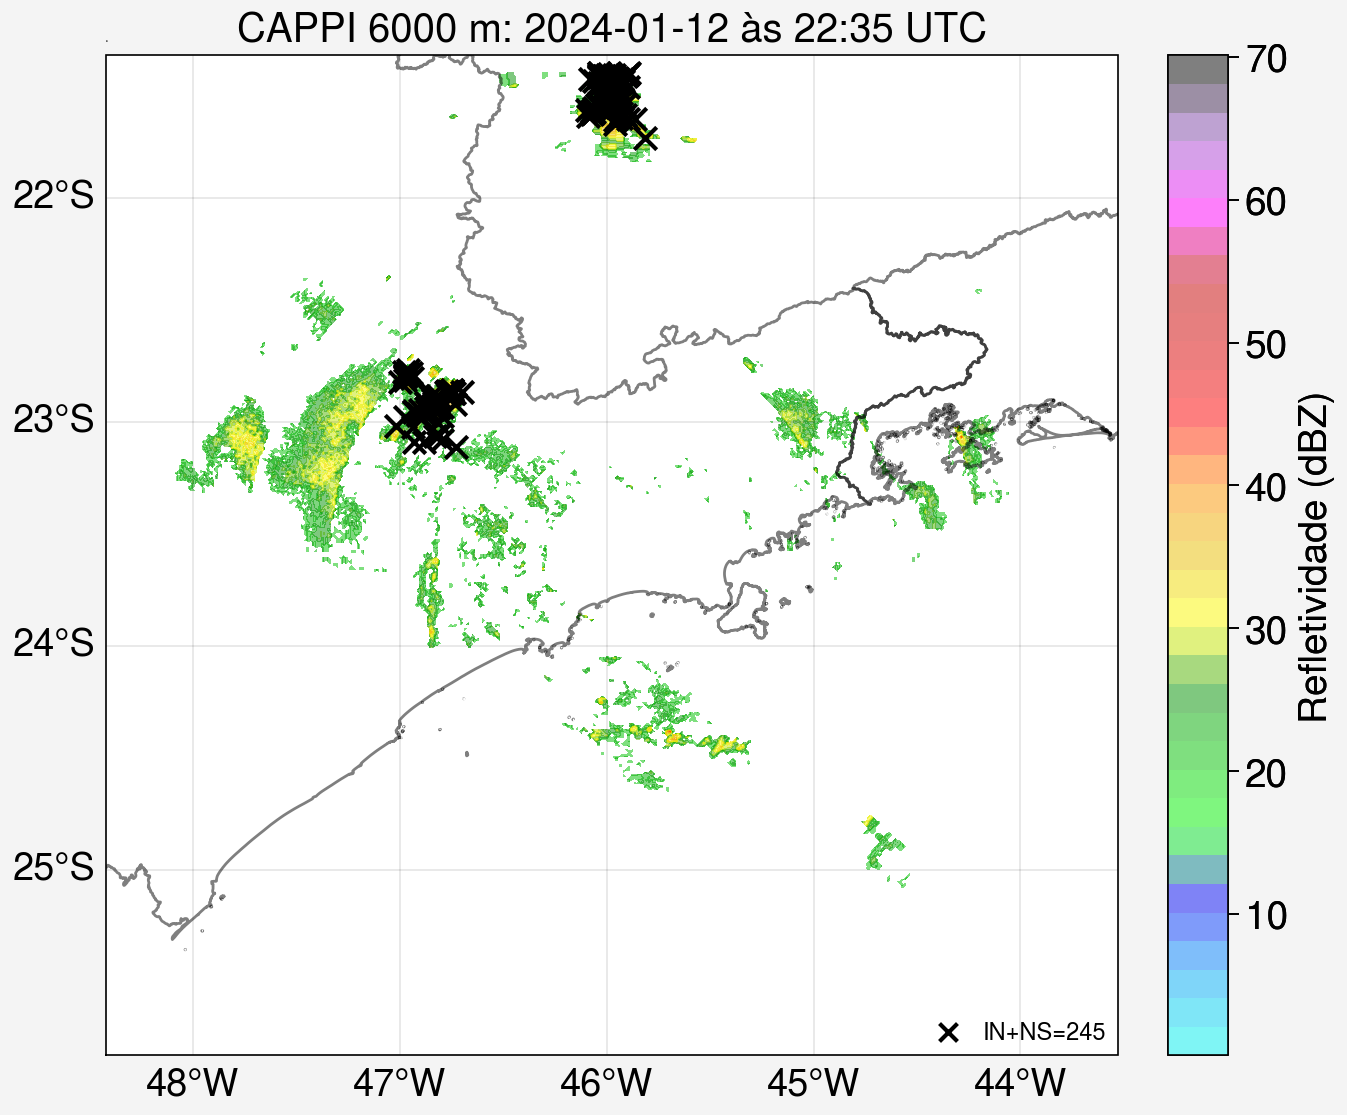

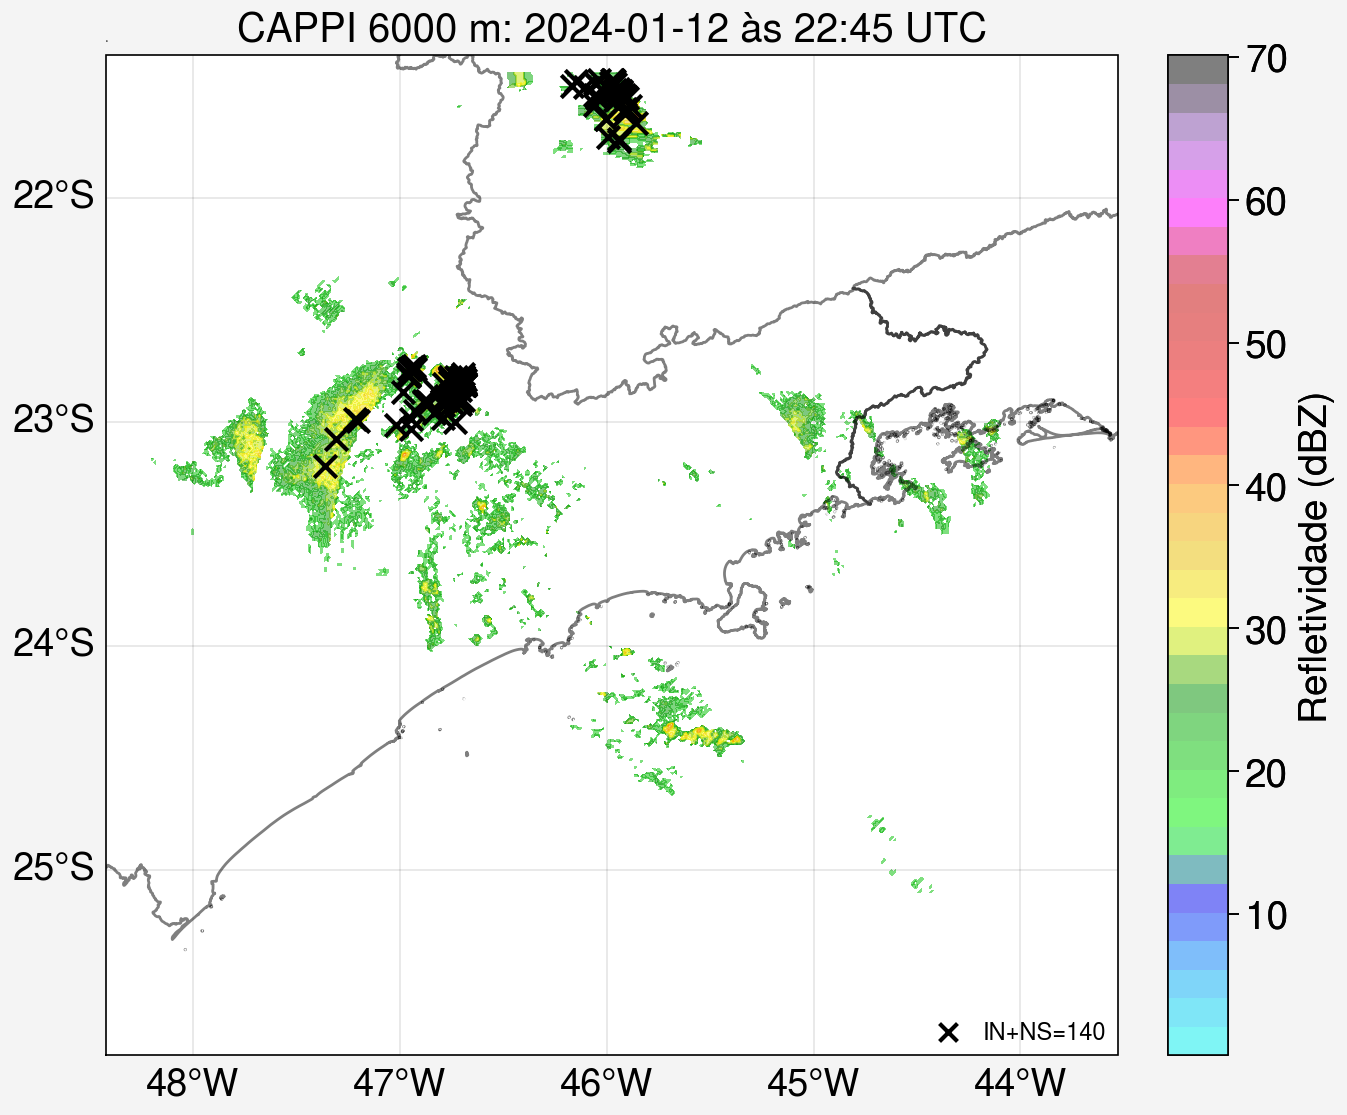

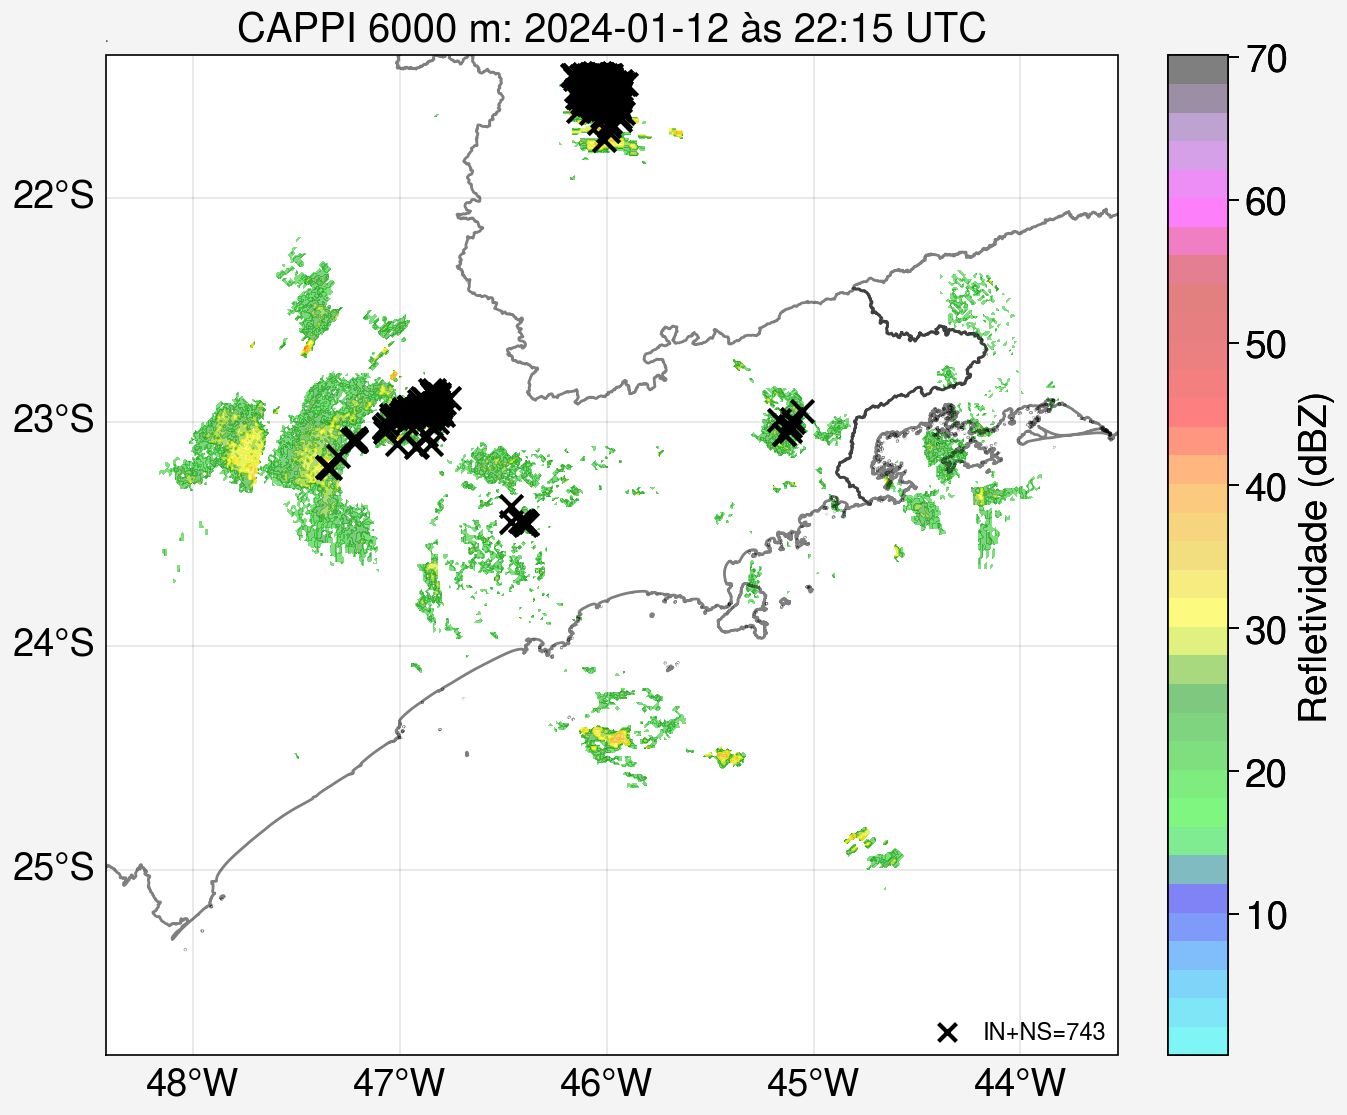

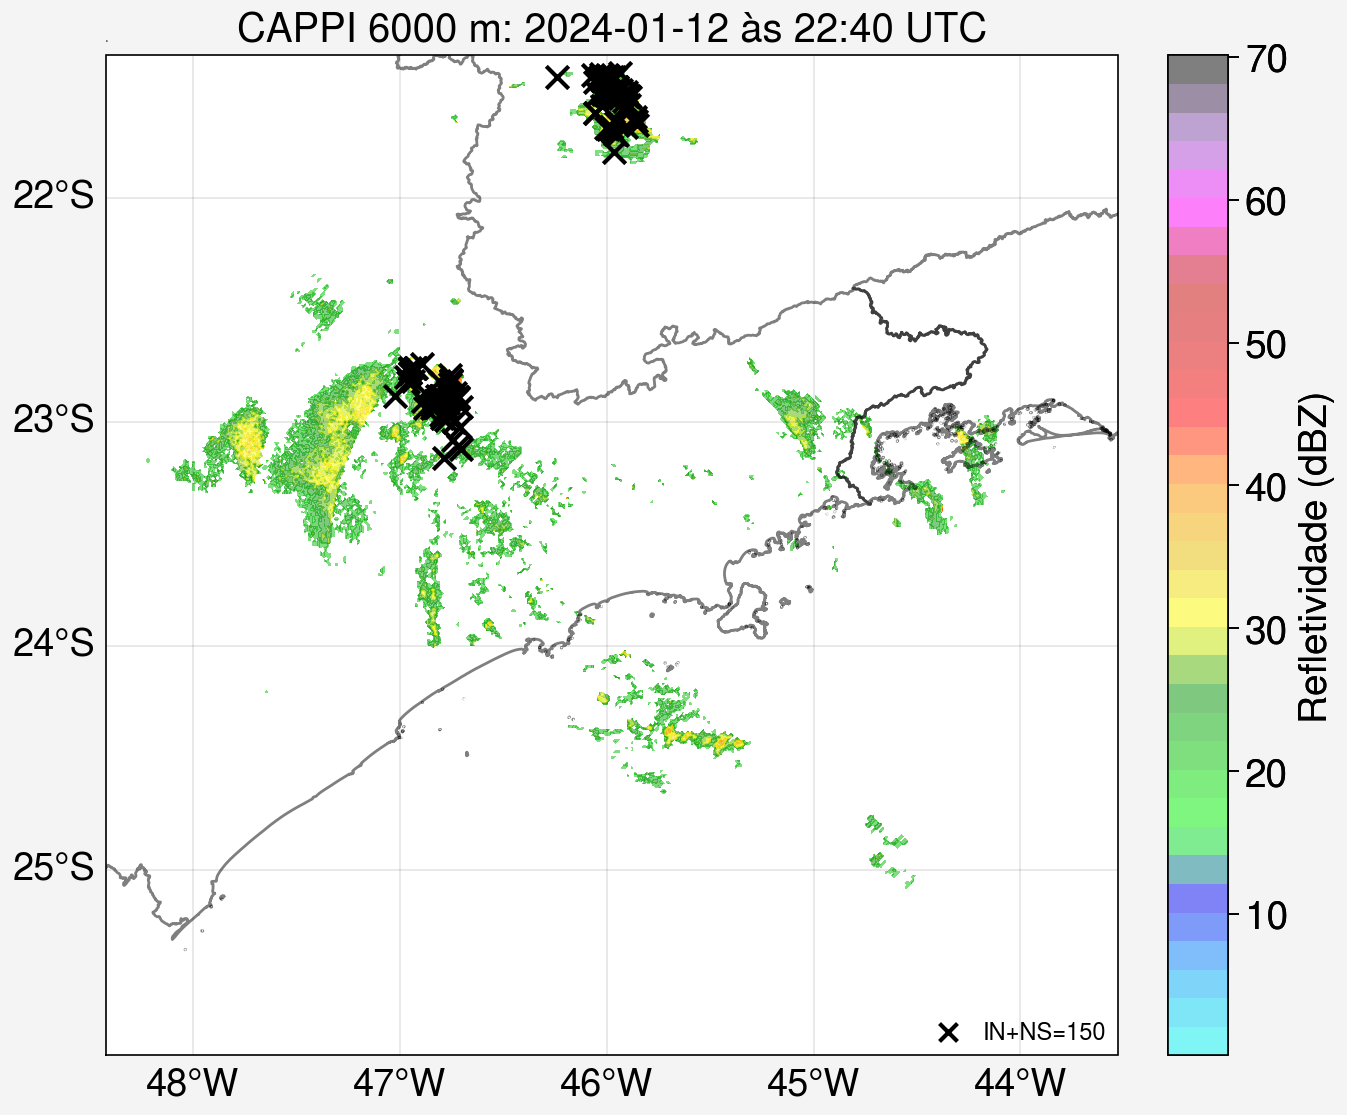

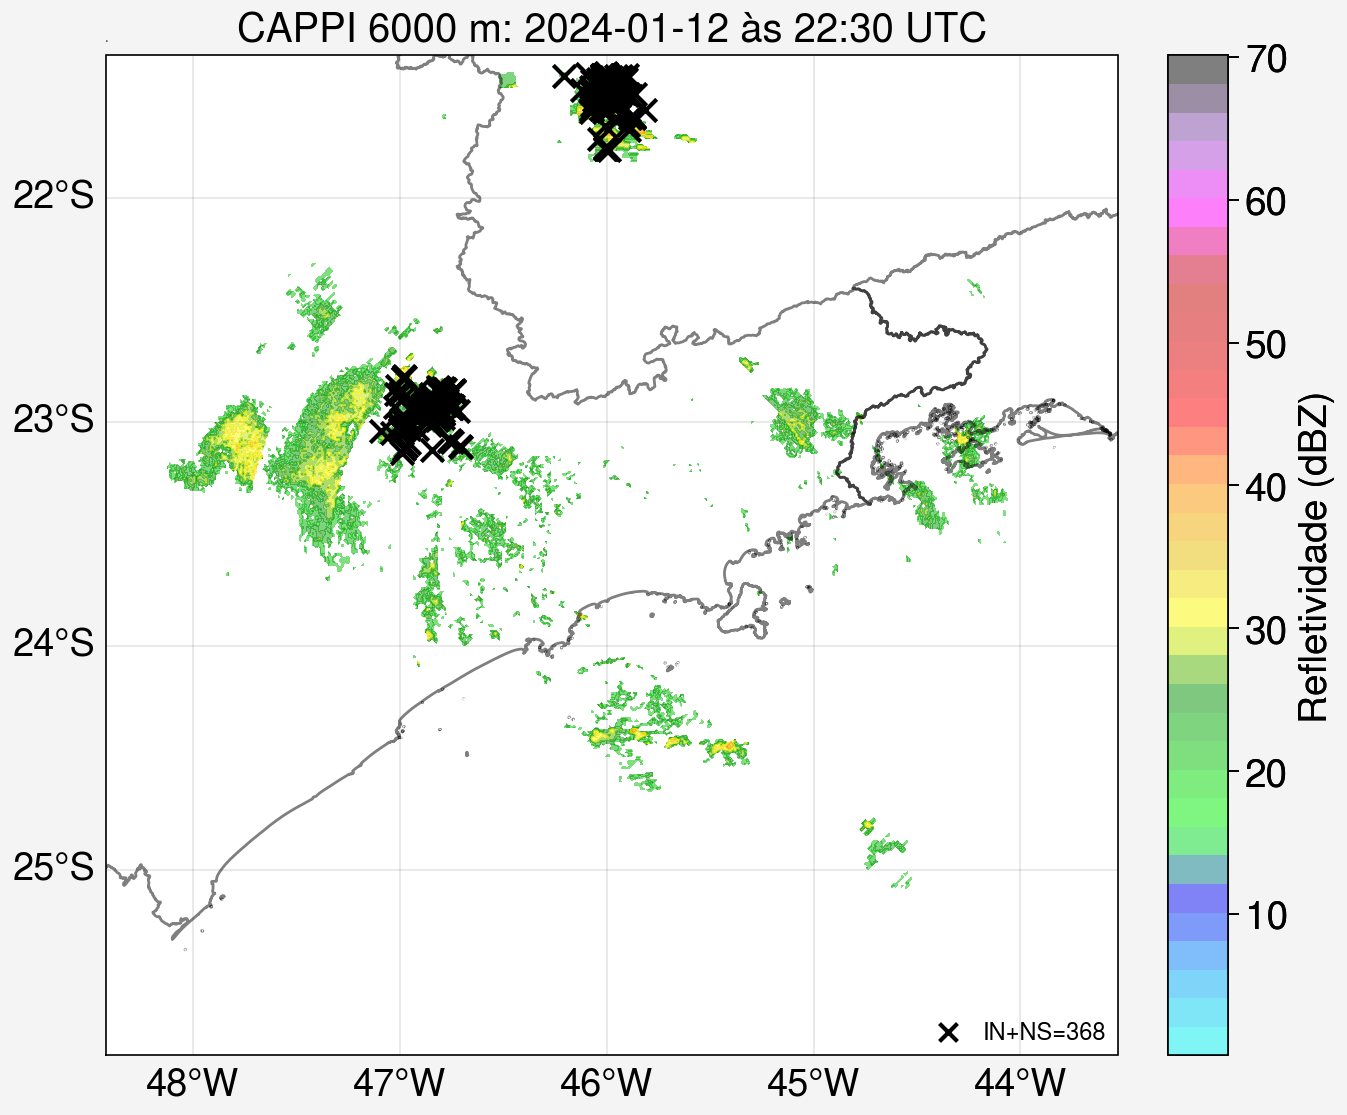

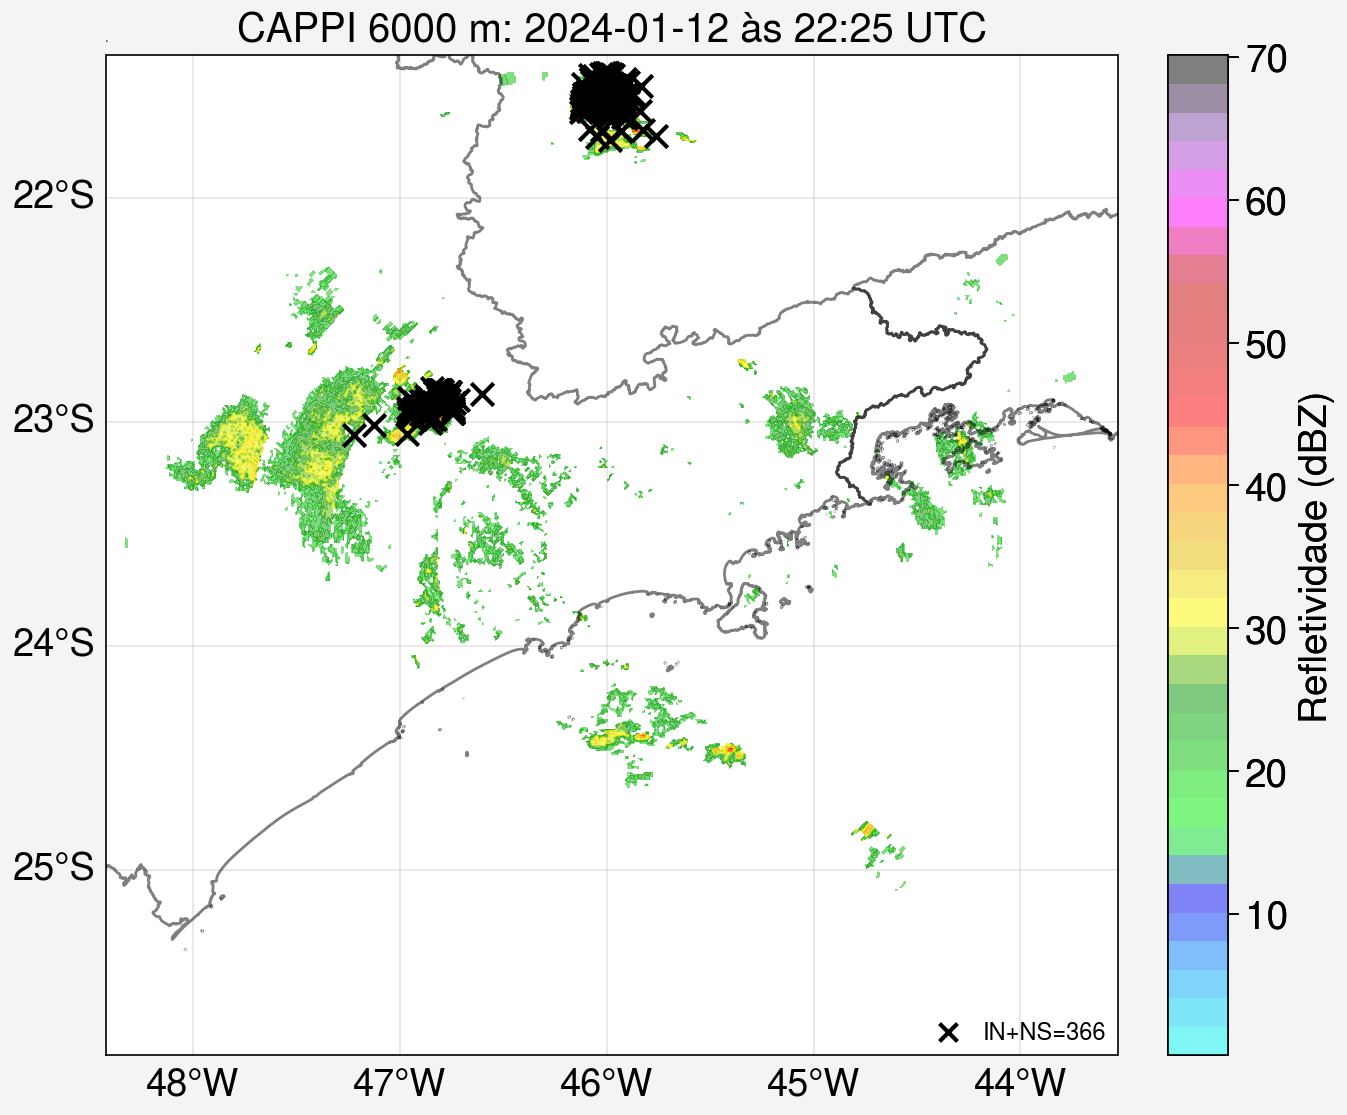

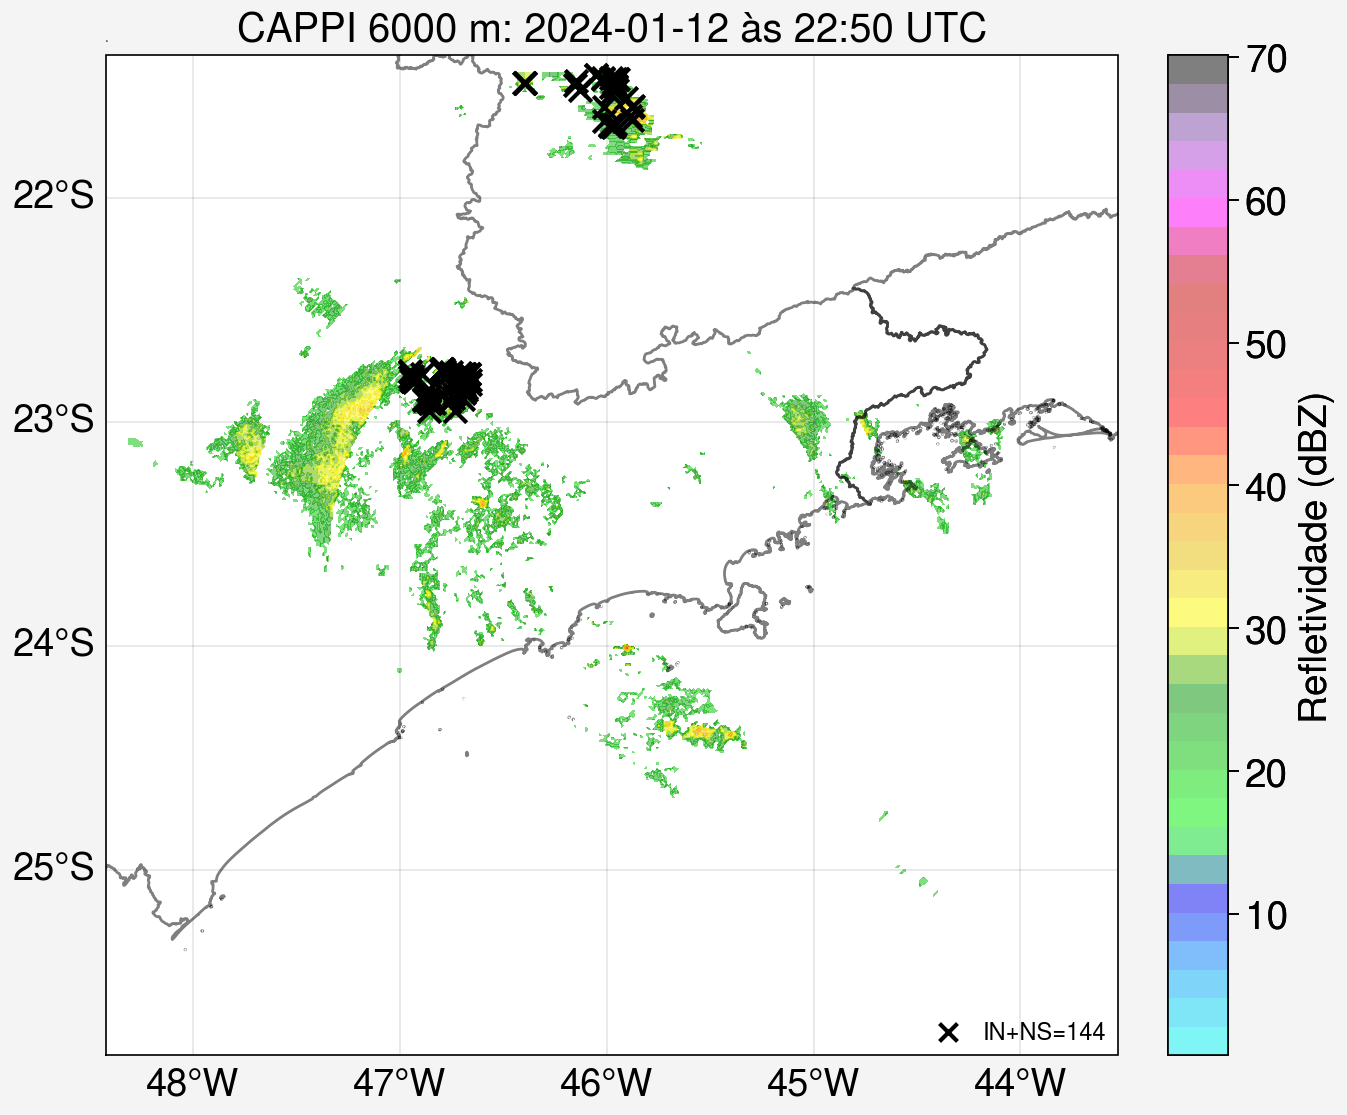

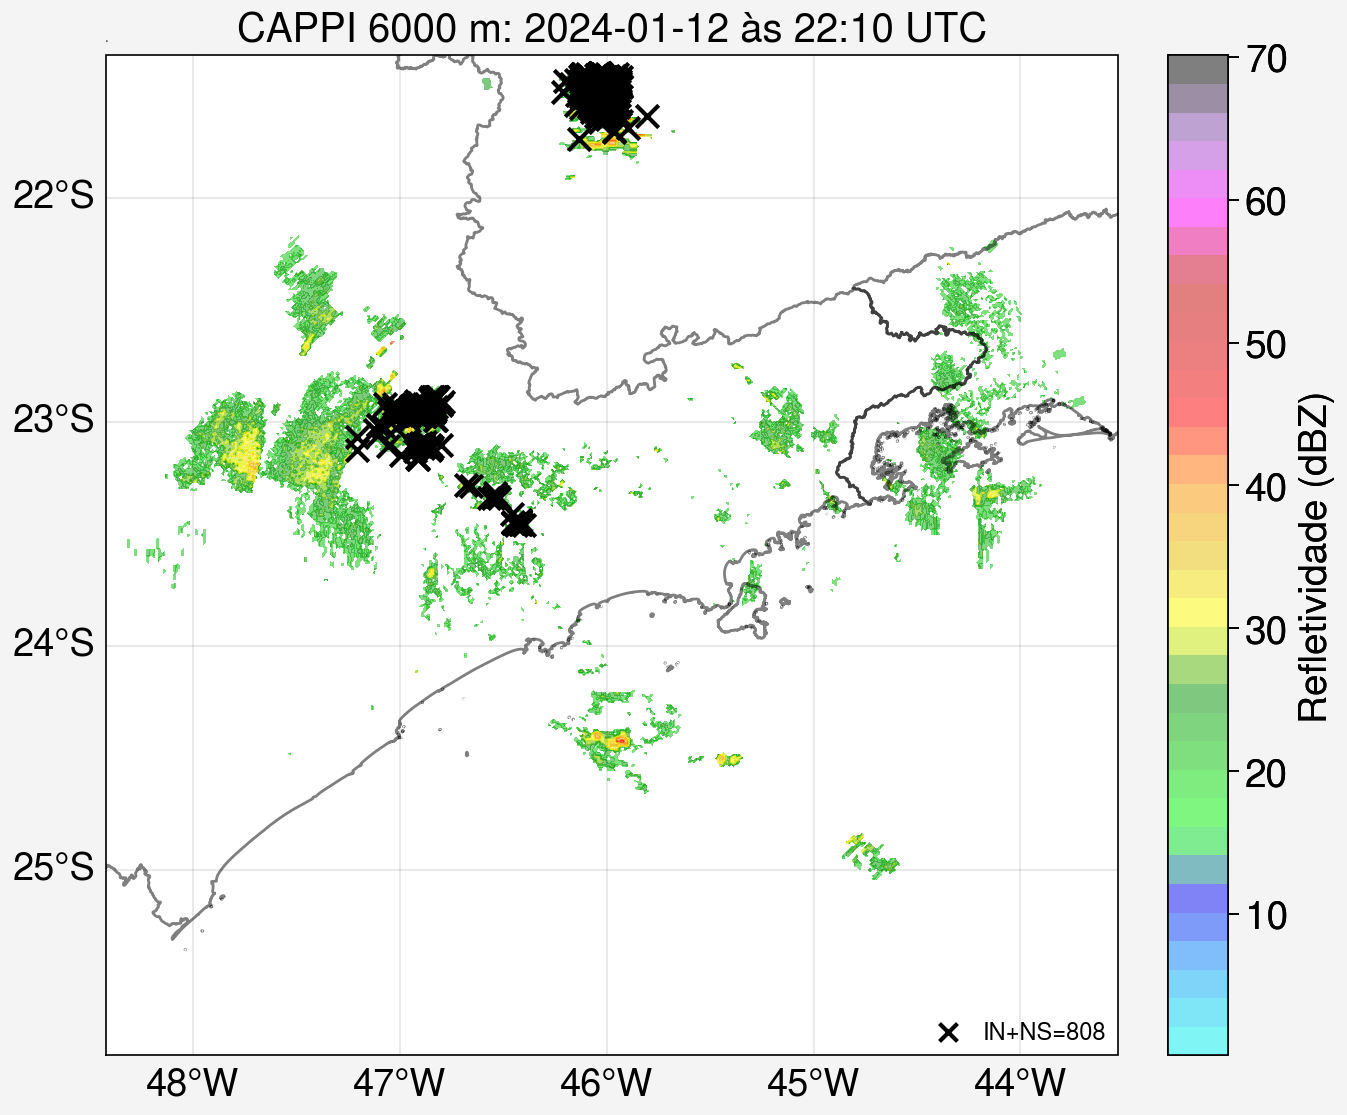

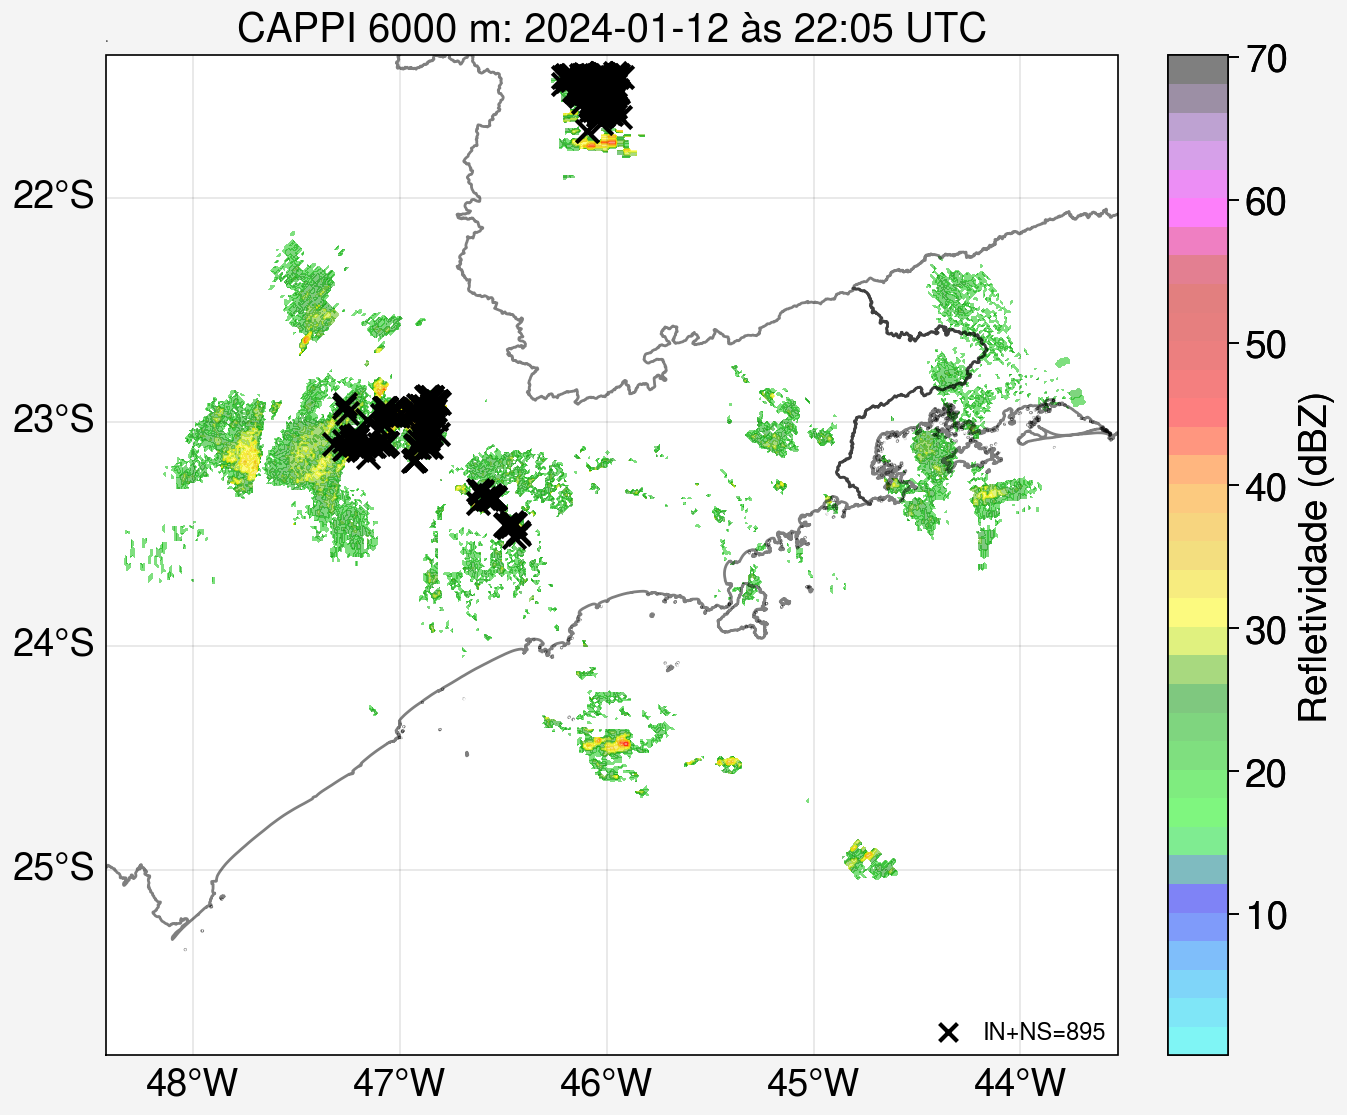

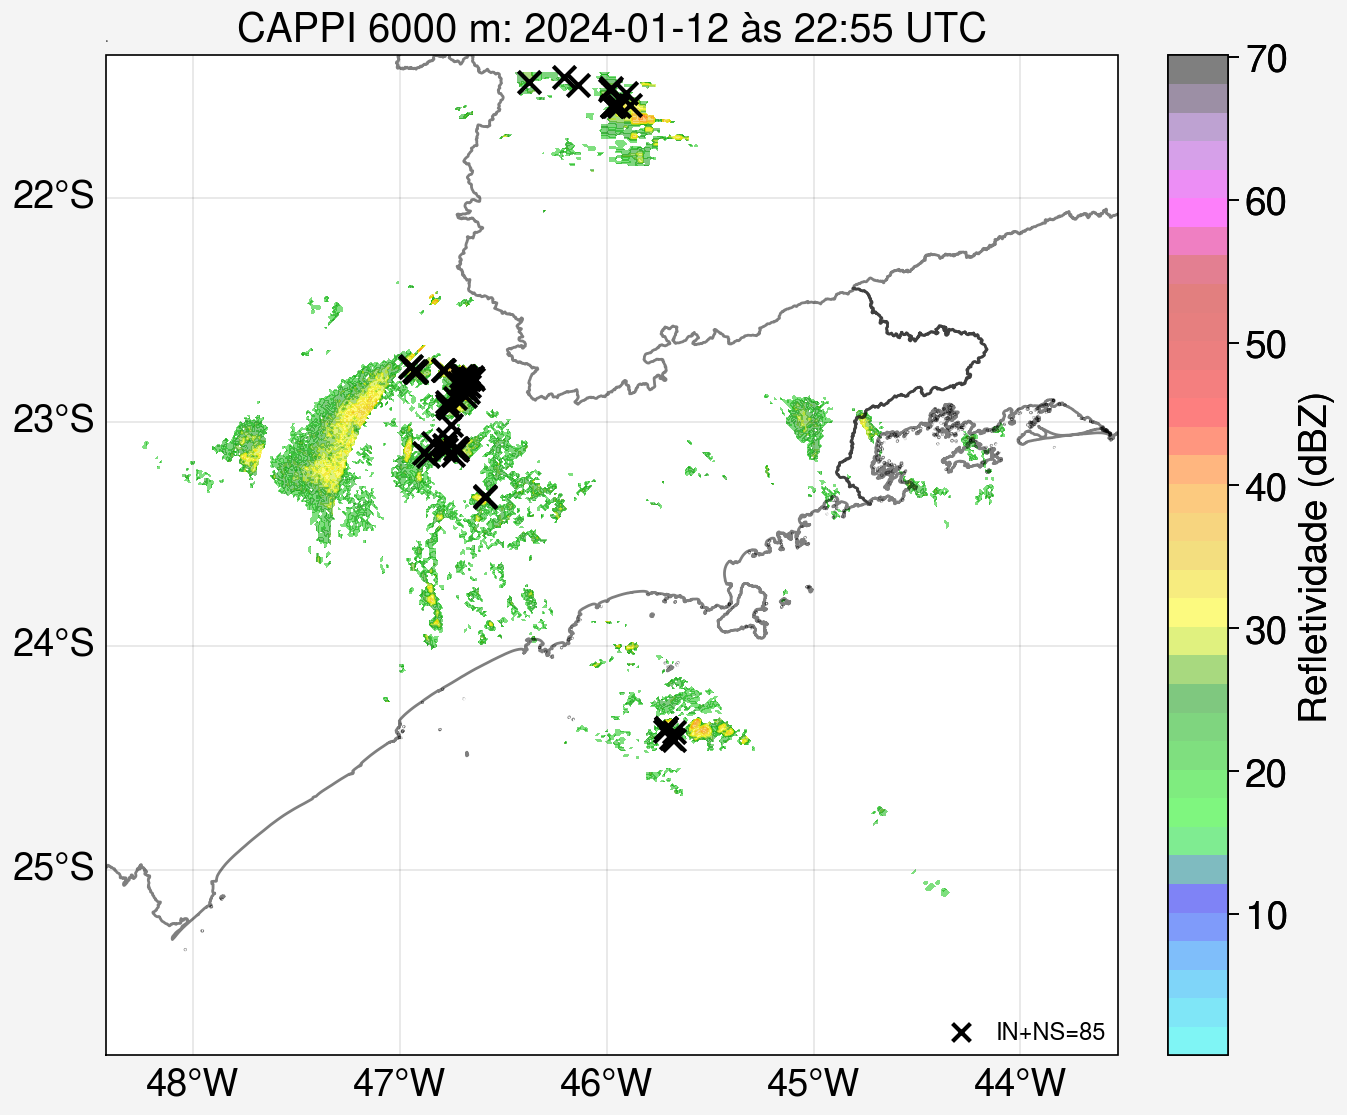

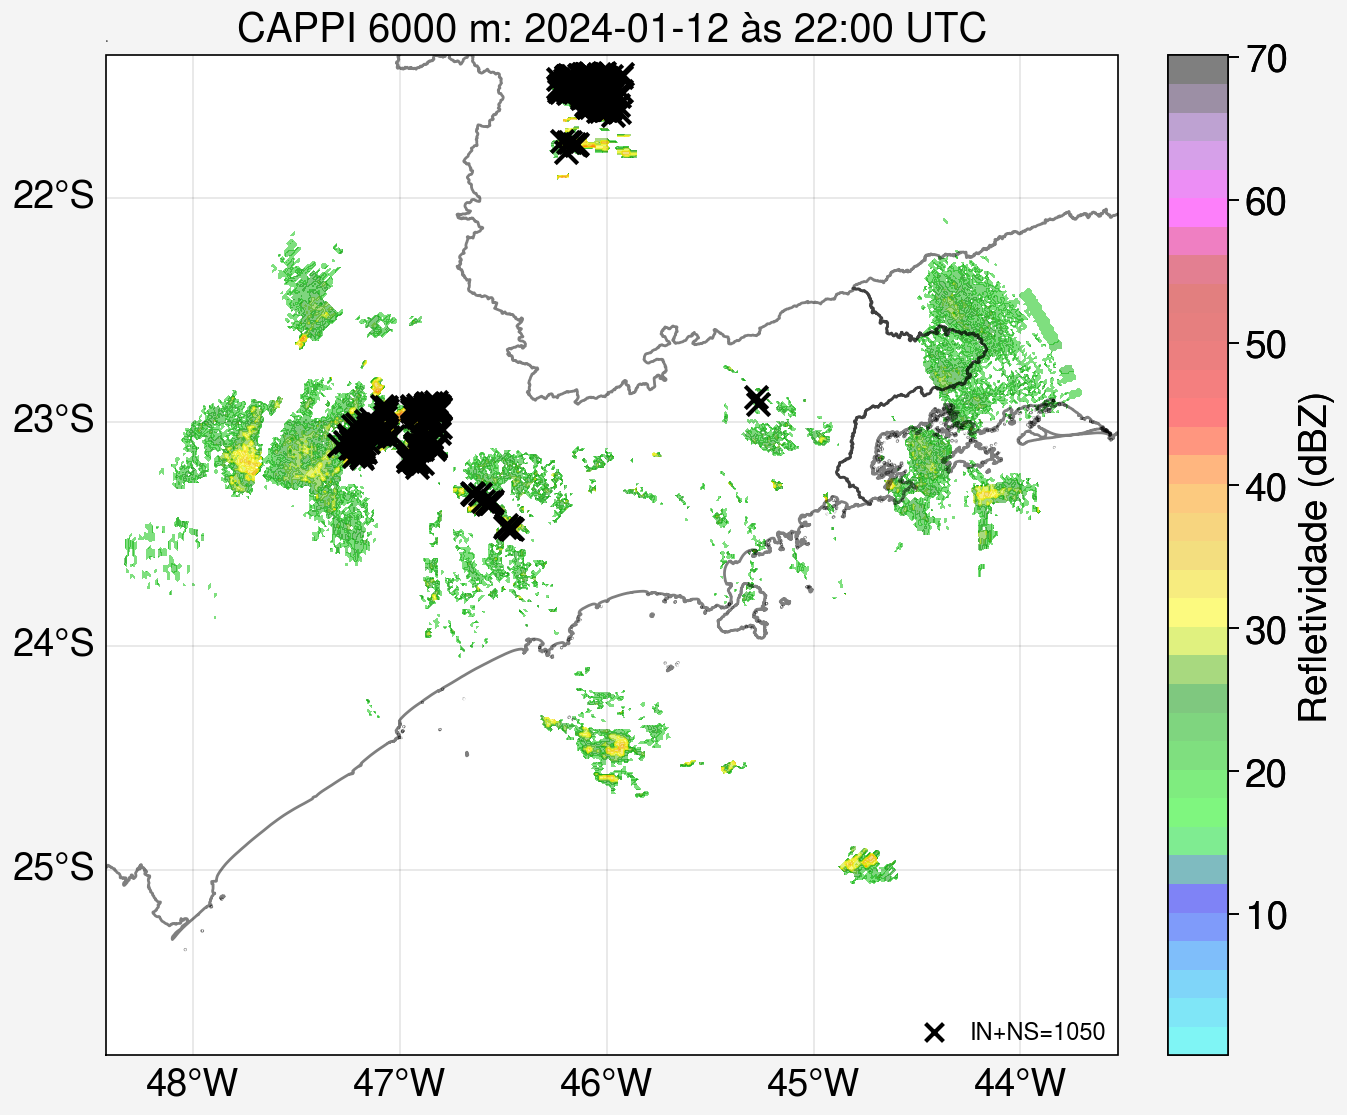

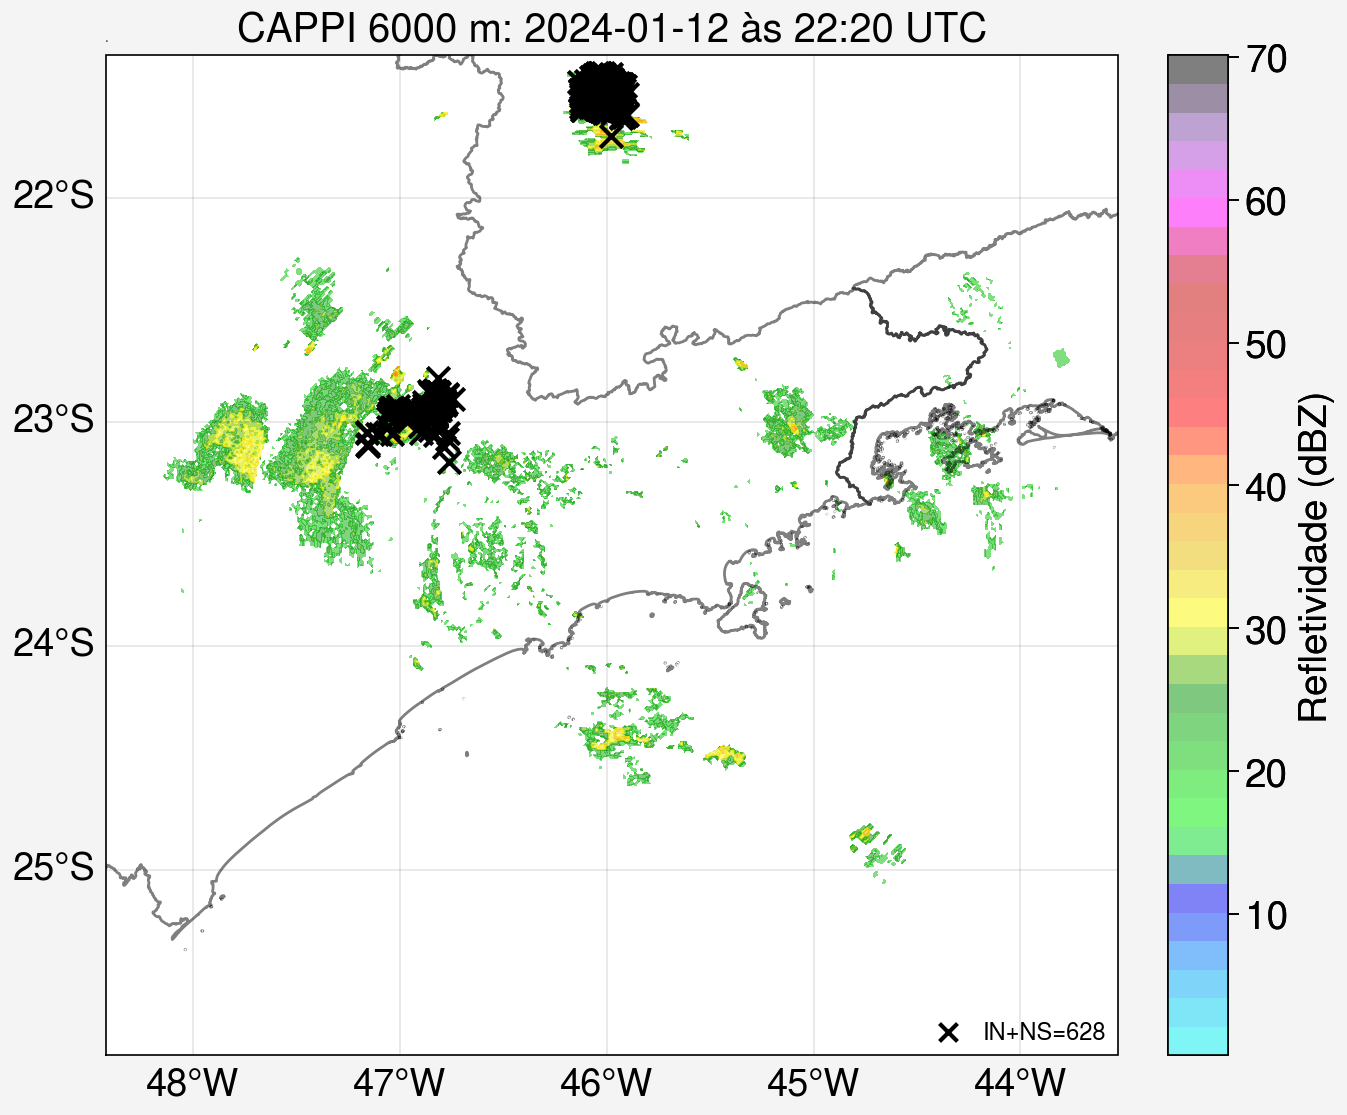

In [24]:
######################## Chamando a função que cria e salva as imagens:
for i in range(len(dics_radares)):
    plota_junto(cappis_filtrados[i], dics_radares[i], lista_dfraios2[i])